# 1.Importación de Módulos y Librerías


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow import keras
import gdown
import random
import numpy as np
import sys
import warnings
import zipfile
import re
import keras
from PIL import Image, UnidentifiedImageError
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from skimage import util, transform
import plotly.graph_objects as go
import plotly.subplots as sp
from concurrent.futures import ThreadPoolExecutor

# Configuración de semillas para reproducibilidad
random.seed(0)
keras.utils.set_random_seed(0)
tf.random.set_seed(0)
np.random.seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importar tus funciones de preprocesamiento personalizadas
#importar funciones
import sys
sys.path.append('/content/drive/MyDrive/Proyecto_MDS6/src/')

In [4]:
sys.path.append('/content/drive/MyDrive/Proyecto_MDS6/src/nombre_paquete/preprocessing')
MODULO_DIR_PATH = '/content/drive/MyDrive/Proyecto_MDS6/src/nombre_paquete/preprocessing'
MODULO_FILE_NAME = 'preprocessing_functions.py'
full_file_path = os.path.join(MODULO_DIR_PATH, MODULO_FILE_NAME)

In [5]:
import importlib.util

spec = importlib.util.spec_from_file_location(
        "preprocessing_functions", # Nombre que Python le dará al módulo
        full_file_path             # Ruta completa al archivo .py
    )
preprocessing_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(preprocessing_module) # Ejecuta el código del módulo

from preprocessing_functions import augment_image_simple



In [6]:
sys.path.append('/content/drive/MyDrive/Proyecto_MDS6/src/nombre_paquete/training')
MODULO_DIR_PATH = '/content/drive/MyDrive/Proyecto_MDS6/src/nombre_paquete/training'
MODULO_FILE_NAME = 'preprocess_image.py'
full_file_path = os.path.join(MODULO_DIR_PATH, MODULO_FILE_NAME)

In [7]:
spec = importlib.util.spec_from_file_location(
        "preprocess_image", # Nombre que Python le dará al módulo
        full_file_path             # Ruta completa al archivo .py
    )
preprocessing_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(preprocessing_module) # Ejecuta el código del módulo

from preprocess_image import preprocess_image


In [8]:
import inspect

print(inspect.getsource(preprocess_image))


def preprocess_image(image, label):
    # Usa la ruta completa desde el módulo 'tf'
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label



# 2. Carga o Adquisición de Datos

In [9]:
train_dir = '/content/drive/MyDrive/DL-Proyecto/Data/Train/Train'
test_dir = '/content/drive/MyDrive/DL-Proyecto/Data/Test/Test'
val_dir = '/content/drive/MyDrive/DL-Proyecto/Data/Validation/Validation'

df_dir = '/content/drive/MyDrive/DL-Proyecto/Data/data_completa'


In [10]:
## Cargar dataset
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)



Found 1322 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


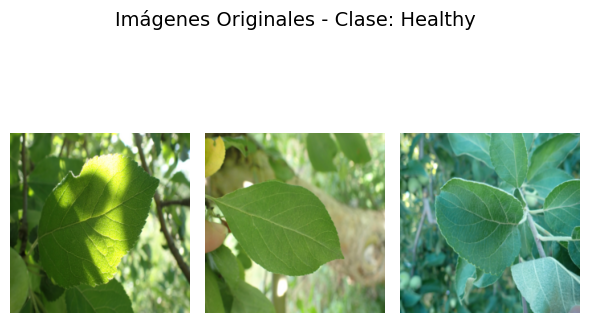

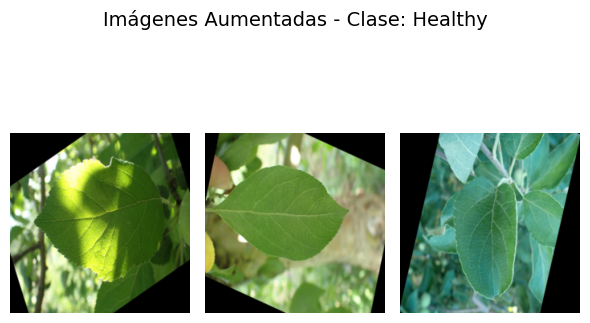

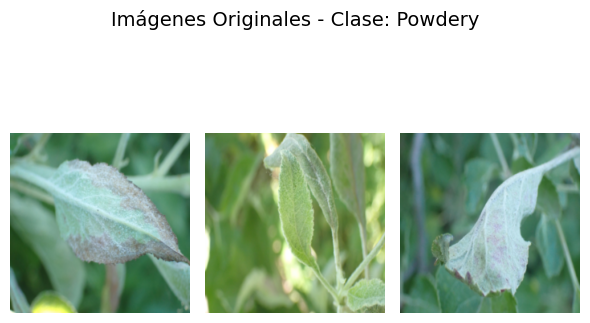

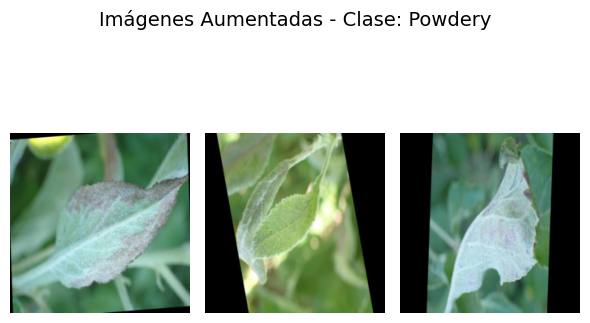

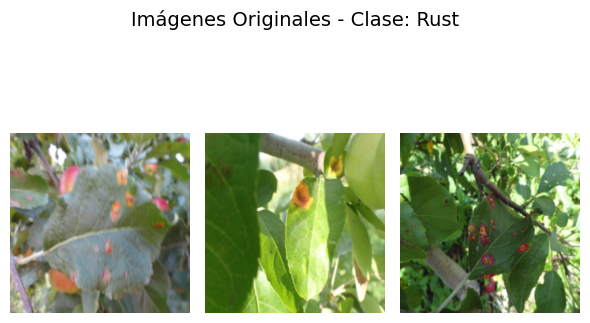

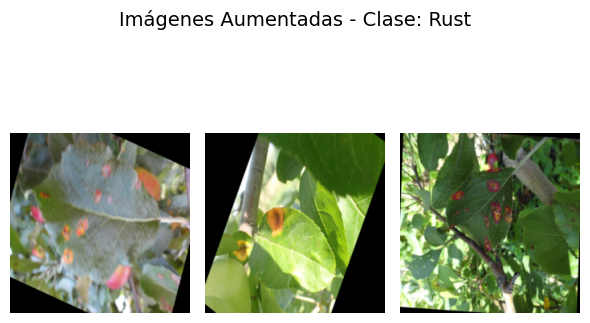

In [12]:
class_names = train_ds.class_names

all_image_paths = []
all_labels = []
for class_name in class_names:
    class_dir = os.path.join(df_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            all_image_paths.append(img_path)
            all_labels.append(class_name)

# --- Parámetros de Aumento y Visualización ---
TARGET_SHAPE = [224, 224]
NUM_IMAGES_TO_SHOW_PER_CLASS = 3

sample_images_data = [] # Para almacenar arrays de imágenes procesadas
sample_labels_data = [] # Para almacenar las etiquetas de las imágenes procesadas

for class_name in class_names:

    # Filtra las rutas de imágenes para la clase actual
    class_paths = [p for p, l in zip(all_image_paths, all_labels) if l == class_name]
    np.random.shuffle(class_paths) # Mezcla para tomar muestras aleatorias

    sample_image_paths = class_paths[:NUM_IMAGES_TO_SHOW_PER_CLASS]

    original_images_for_display = []
    augmented_images_for_display = []

    for img_path in sample_image_paths:
        # Cargar la imagen usando Keras, asegurar que sea RGB y normalizar a [0, 1]
        img_pil = load_img(img_path)
        img_array_raw = img_to_array(img_pil)

        if img_array_raw.shape[2] == 4: # Si es RGBA, quitar el canal alfa
            img_array_raw = img_array_raw[:, :, :3]
        elif img_array_raw.ndim == 2: # Si es escala de grises, convertir a RGB
            img_array_raw = np.stack([img_array_raw]*3, axis=-1)

        # Normalizar a [0, 1] y asegurar el tipo float32 para skimage
        image_normalized = img_array_raw.astype(np.float32) / 255.0

        # Redimensionar la imagen original para visualización consistente
        original_resized_img = transform.resize(image_normalized, TARGET_SHAPE, anti_aliasing=True)

        # Aplicar la función de aumento simple
        aug_img = augment_image_simple(image_normalized.copy(), shape=TARGET_SHAPE, flip=True, rotate=[-180, 180])

        original_images_for_display.append(original_resized_img)
        augmented_images_for_display.append(aug_img)

    # --- Visualización de Imágenes Originales ---
    plt.figure(figsize=(2 * NUM_IMAGES_TO_SHOW_PER_CLASS, 4))
    plt.suptitle(f'Imágenes Originales - Clase: {class_name}', fontsize=14)
    for i, disp_img in enumerate(original_images_for_display):
        plt.subplot(1, NUM_IMAGES_TO_SHOW_PER_CLASS, i + 1)
        plt.imshow(disp_img)
        plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Visualización de Imágenes Aumentadas ---
    plt.figure(figsize=(2 * NUM_IMAGES_TO_SHOW_PER_CLASS, 4))
    plt.suptitle(f'Imágenes Aumentadas - Clase: {class_name}', fontsize=14)
    for i, disp_aug_img in enumerate(augmented_images_for_display):
        plt.subplot(1, NUM_IMAGES_TO_SHOW_PER_CLASS, i + 1)
        plt.imshow(disp_aug_img)
        plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 3. Configuración del aumento de datos (Data Augmentation)

---

El aumento de datos es una técnica crucial para evitar el sobreajuste (overfitting) en modelos de aprendizaje profundo, especialmente cuando se trabaja con datasets pequeños.

Al aplicar diversas transformaciones a las imágenes de entrenamiento, aumentamos artificialmente la diversidad de nuestro dataset, haciendo que el modelo sea más robusto y generalice mejor a nuevas imágenes no vistas.

`ImageDataGenerator` de Keras es muy útil para aplicar estas transformaciones sobre la marcha durante el entrenamiento del modelo. Esto significa que no es requerido almacenar todas las imágenes aumentadas en tu disco, lo cual es una gran ventaja dadas las limitaciones de RAM que ofrece el nivel gratuito de Google Colab.

Las transformaciones aplicadas fueron:


*   **Normalización:** Reescala los valores de píxeles de [0, 255] a [0, 1]. Esto es un paso de preprocesamiento estándar y necesario para la mayoría de las redes neuronales.

*   **Rotación:** Rota las imágenes aleatoriamente hasta 20 grados (en sentido horario o antihorario). Ayuda al modelo a ser insensible a la orientación de las hojas de las plantas.

* **Desplazamiento Horizontal:** Desplaza las imágenes horizontalmente de forma aleatoria hasta un 20% de su ancho total.

* **Desplazamiento Vertical:** Desplaza las imágenes verticalmente de forma aleatoria hasta un 20% de su altura total.

* **Cizallamiento (Shear):** Aplica transformaciones de cizallamiento (como inclinar la imagen) de forma aleatoria. Esto simula perspectivas diferentes.

* **Zoom:** Aplica un zoom aleatorio a las imágenes. Un valor de 0.2 significa que la imagen puede acercarse o alejarse hasta un 20%.

* **Giro Horizontal:** Voltea las imágenes horizontalmente de forma aleatoria. Útil si la orientación horizontal del objeto no es importante (ej., Una hoja girada sigue siendo una hoja).

* **Modo de Relleno:** Cuando se aplican transformaciones que crean nuevos píxeles (como rotación o desplazamiento), este parámetro define cómo se rellenan esos píxeles. `nearest` (más cercano) simplemente copia el píxel más cercano, lo cual es una opción común y efectiva.


In [13]:
# --- Data Augmentation y preprocesamiento para el conjunto de entrenamiento ---
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalizar los valores de píxeles a [0, 1]
    rotation_range=20,          # Rotar imágenes aleatoriamente hasta 20 grados
    width_shift_range=0.2,      # Desplazar imágenes horizontalmente aleatoriamente
    height_shift_range=0.2,     # Desplazar imágenes verticalmente aleatoriamente
    shear_range=0.2,            # Aplicar transformaciones de cizallamiento
    zoom_range=0.2,             # Aplicar zoom aleatorio
    horizontal_flip=True,       # Voltear imágenes horizontalmente aleatoriamente
    fill_mode='nearest'         # Rellenar píxeles nuevos después de transformaciones
)

Para el conjunto de validación y prueba, generalmente NO se aplica Data Augmentation (excepto la normalización), ya que estos conjuntos deben representar el rendimiento real del modelo en datos "limpios" y no modificados artificialmente.

Un generador separado para validación/prueba solo con `rescale=1./255` es lo habitual.

In [14]:
# --- Preprocesamiento para el conjunto de validación y prueba (sin augmentation) ---
# Solo se aplica el reescalado, ya que no queremos "aumentar" estos conjuntos.
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
batch_size = 128
img_height = 180
img_width = 180
# Generador para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # O 'binary' si tienes solo 2 clases
)

Found 1322 images belonging to 3 classes.


In [16]:
# Generador para el conjunto de validación
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 60 images belonging to 3 classes.


In [17]:
# Generador para el conjunto de prueba
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Es importante no barajar el conjunto de prueba para evaluar el rendimiento
)

Found 150 images belonging to 3 classes.


In [18]:
for data_batch, labels_batch in train_generator:
  print("Forma del lote de datos de entrenamiento:", data_batch.shape)
  print("Forma del lote de etiquetas de entrenamiento:", labels_batch.shape)
  break

Forma del lote de datos de entrenamiento: (128, 180, 180, 3)
Forma del lote de etiquetas de entrenamiento: (128, 3)


# 4. Entrenamiento del Modelo Fine Tuning


Cuando el problema que intentamos resolver con imágenes es muy diferente al problema original para el que el modelo fue entrenado (como identificar objetos cotidianos), simplemente usar el modelo como un extractor de características fijo no siempre da los mejores resultados.

Aquí es donde entra el ajuste fino o fine-tuning. En lugar de congelar todas las capas, el fine-tuning nos permite entrenar y adaptar algunas o todas las capas del modelo pre-entrenado a nuestro nuevo y particular conjunto de datos. Esto permite que el modelo aprenda características más relevantes para nuestra tarea específica. Sin embargo, este proceso requiere más tiempo de entrenamiento y una cuidadosa experimentación.

Para que el ajuste fino sea exitoso, considera lo siguiente:

Calentamiento (Warm-up): Es buena idea empezar entrenando solo las nuevas capas que añadimos al modelo. Esto evita que los pesos aleatorios de estas nuevas capas "dañen" el conocimiento ya adquirido por las capas más profundas del modelo.

Tasa de aprendizaje (Learning Rate): Utiliza una tasa de aprendizaje muy pequeña. Esto asegura que los ajustes a los pesos existentes del modelo sean graduales y no borren el conocimiento valioso que ya tiene.

Congelamiento Estratégico: No siempre es necesario (o recomendable) entrenar todas las capas del modelo pre-entrenado. A menudo, las primeras capas de una red convolucional aprenden características muy básicas (como bordes o texturas) que son universales. Experimenta con cuántas capas descongelas y entrenas; a veces solo ajustar las capas más profundas es suficiente.

**Arquitectura**


---


In [19]:
# Cargamos EfficientNet sin el top (capas densas del final)
extractor = keras.applications.EfficientNetB0(weights='imagenet',
                                            include_top=False,
                                            input_shape=(224, 224, 3))

# Congelamos el extractor de características
for layer in extractor.layers:
    layer.trainable=False

# Creamos una capa de pooling para eliminar los ejes no deseados
pool = keras.layers.GlobalAveragePooling2D()(extractor.output)
# Agregamos una capa densa
dense1 = keras.layers.Dense(units=32, activation="relu")(pool)
# Agregamos dropout para regularización
drop1 = keras.layers.Dropout(0.2)(dense1)
# Agregamos una capa de salida
dense2 = keras.layers.Dense(units=len(class_names), activation="softmax")(drop1)
ft_model = keras.models.Model(inputs=[extractor.input], outputs=[dense2])
ft_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,090,662 (15.60 MB)

 Trainable params: 41,091 (160.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Para la definición del modelo, se adaptó la arquitectura de EfficientNetB0 a nuestro problema específico utilizando los siguientes componentes y configuraciones:

* (Extractor): Esta es la parte principal del modelo pre-entrenado mediante el modelo EfficientNetB0. Al usar include_top=False, se eliminan las capas finales de clasificación de este modelo, adaptaptándolo al problema específico que deseamos resolver (clasificación de enfermedades de plantas).

*   Non-trainable params: La mayoría de los parámetros (pesos y sesgos) de esta sección están "congelados" (layer.trainable=False). Esto significa que no se modificarán durante el entrenamiento inicial (el "warming up").

*   GlobalAveragePooling2D: Esta capa toma la salida del extractor (que es un tensor 3D) y la reduce a un vector 1D. Básicamente, calcula el promedio de los valores de cada mapa de características ayudando a reducir la dimensionalidad.


*   Dense (Capa Densa 1): Capa de adaptación del modelo a nuestro problema de clasificación. Se definen 32 neuronas y se utiliza función de activación ReLU

*  Dropout: Se utiliza técnica de regularización del 20% con el objetivo de prevenir el sobreajuste.

*   Dense (Capa Densa 2 - Salida): Capa se salida con número de neuronas igual al número de clases para este caso 3 ('Healthy', 'Powdery', 'Rust'), con función de activación softmax ya que enfrentamos un problema multiclase.

Los resultados de la arquitectura construida genera como resultado el siguiente summary:

Las imágenes de entrada se procesan con dimensiones de 224x224 píxeles y 3 canales de color (RGB). El modelo completo consta de 4,090,662 parámetros. Sin embargo, en la fase de entrenamiento inicial (y ajustado a nuestro problema de clasificación), solo 41,091 parámetros son "entrenables" (es decir, se ajustarán durante el entrenamiento). Dado que el conjunto de datos es limitado y entrenar una gran cantidad de parámetros requiere más datos y recursos computacionales, se optó por congelar la mayoría de los parámetros del modelo EfficientNetB0 original y entrenar únicamente las capas añadidas.

Non-trainable params nos indica los parámetros que no se modificarán durante el entrenamiento actual, para este caso 4,049,571.


**Calentamiento (*Warming Up*)**

---

Comenzamos entrenando sólo un poco (en este caso máximo 10 _epochs_) las nuevas capas densas del final fijando el learning rate en $10^{-3}$.Guardamos el mejor modelo para luego empezar desde ese punto el entrenamiento de _Fine Tuning_.

In [20]:
batch_size = 32
img_height = 224
img_width = 224

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1322 files belonging to 3 classes.
Found 150 files belonging to 3 classes.


In [21]:
train_dataset = train_dataset.map(preprocess_image)
validation_dataset = validation_dataset.map(preprocess_image)

In [22]:
ft_model.compile(loss="sparse_categorical_crossentropy",
                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 metrics=["accuracy"])

# Definimos el callback
best_callback = keras.callbacks.ModelCheckpoint(filepath="warming_up.weights.h5",
                                                   monitor="val_loss",
                                                   verbose=False,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="min")

history_warmup = ft_model.fit(train_dataset,
                              validation_data=validation_dataset,
                              epochs=10,
                              callbacks=[best_callback])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


42/42 ━━━━━━━━━━━━━━━━━━━━ 408s 9s/step - accuracy: 0.7738 - loss: 0.6024 - val_accuracy: 0.9467 - val_loss: 0.1670
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9776 - loss: 0.1002 - val_accuracy: 0.9733 - val_loss: 0.1209
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9863 - loss: 0.0684 - val_accuracy: 0.9533 - val_loss: 0.1093
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9898 - loss: 0.0516 - val_accuracy: 0.9733 - val_loss: 0.1117
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9922 - loss: 0.0357 - val_accuracy: 0.9733 - val_loss: 0.0998
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9944 - loss: 0.0296 - val_accuracy: 0.9800 - val_loss: 0.0962
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9957 - loss: 0.0239 - val_accuracy: 0.9733 - val_loss: 0.1033
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9950 - loss: 0.0248 - val_accuracy: 0.9733 - val_loss: 0.0976
E

**Ajuste Fino (_Fine Tuning_)**

---

Ahora disminuimos el learning rate y permitimos entrenar todas las capas de la red. Se Cargan los pesos obtenidos durante el calentamiento y se baja la tasa de aprendizaje a $10^{-4}$.

In [23]:
# Hacemos entrenables todas las capas
for layer in ft_model.layers:
    layer.trainable = True

# Disminuímos el learning rate
ft_model.compile(loss="sparse_categorical_crossentropy",
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=["accuracy"])

# Cargamos los pesos del calentamiento
ft_model.load_weights("warming_up.weights.h5")

# Definimos el callback
best_callback = keras.callbacks.ModelCheckpoint(filepath="fine_tuning.weights.h5",
                                                   monitor="val_loss",
                                                   verbose=False,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="min")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


El modelo converge de manera bastante buena, obteniendo para algunas epoch valores de accuracy iguales a 1, para 6 epoch ya se tienen resultados aceptables. En comparación con el modelo entrenado de la red convolucional, se obtienen mejores resultados, aunque posteriormente debe evaluarse con mas detenimiento los parámetros de evaluación de los modelos.

In [24]:
# Entrenamos
hist_ft = ft_model.fit(train_dataset,
                              validation_data=validation_dataset,
                              epochs=20,
                              callbacks=[best_callback])

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.8642 - loss: 0.4310 - val_accuracy: 0.9667 - val_loss: 0.1508
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9939 - loss: 0.0461 - val_accuracy: 0.9800 - val_loss: 0.1367
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9967 - loss: 0.0179 - val_accuracy: 0.9800 - val_loss: 0.1126
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9984 - loss: 0.0154 - val_accuracy: 0.9800 - val_loss: 0.1062
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9951 - loss: 0.0166 - val_accuracy: 0.9800 - val_loss: 0.1137
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9981 - loss: 0.0103 - val_accuracy: 0.9800 - val_loss: 0.0924
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9987 - loss: 0.0074 - val_accuracy: 0.9800 - val_loss: 0.1060
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9990 - loss: 0.0069 - val_accuracy: 0.9733 - val_los

In [25]:
# Cargamos el mejor modelo
ft_model.load_weights("fine_tuning.weights.h5")

El accuracy en el conjunto de entrenamiento sube rápidamente y alcanza valores cercanos o iguales a 1.00 en pocas épocas (aprox 5 epoch). Esto se debe a la base sólida de entrenamiento del modelo fine tuning.

El loss en el conjunto de entrenamiento disminuye drásticamente, acercándose a cero como es lo esperado.

El  val_accuracy también aumenta rápidamente y alcanza valores muy altos (alrededor de 0.96 - 0.98).

El val_loss disminuye significativamente, lo cual es una buena señal de que el modelo está generalizando bien.

El hecho de que tanto la precisión en entrenamiento como en validación sean altas y que la pérdida en ambos conjuntos sea baja sugiere que el modelo está aprendiendo de manera efectiva y no parece estar sufriendo de un sobreajuste severo dentro de estas 20 épocas. El callback best_callback se aseguró de guardar la versión del modelo que tuvo la mejor val_loss a lo largo de estas épocas.

In [26]:
X_val_list = []
Y_val_list = []

for images, labels in validation_dataset:
    X_val_list.append(images.numpy())
    Y_val_list.append(labels.numpy())

X_val = np.concatenate(X_val_list, axis=0)
Y_val = np.concatenate(Y_val_list, axis=0)

from sklearn.metrics import classification_report


predictions = ft_model.predict(X_val, batch_size=32)
predicted_classes = np.argmax(predictions, axis=1)

print(classification_report(Y_val, predicted_classes))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        50
           1       1.00      0.94      0.97        50
           2       1.00      1.00      1.00        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



**Ajuste Fino grafica evaluacion**

---


Se representa el desempeño del modelo en todos los epoch establecidos. En general se observa un buen ajuste principlamente en la data de entrenamiento.

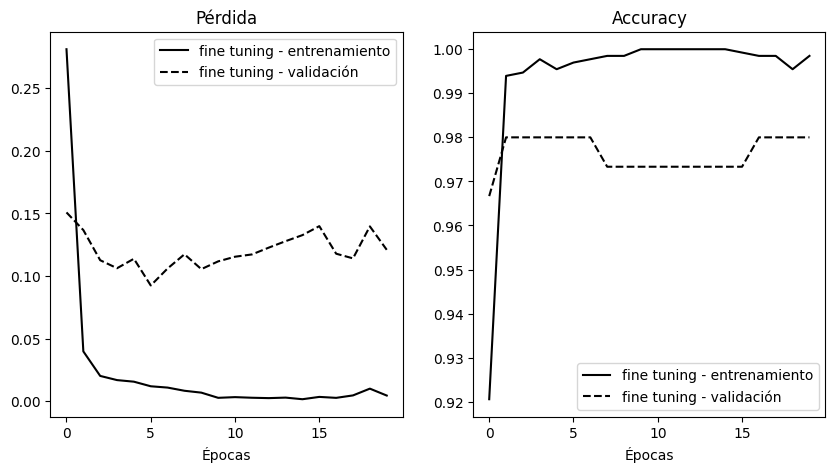

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(hist_ft.history["loss"], "k", label="fine tuning - entrenamiento")
plt.plot(hist_ft.history["val_loss"], "k--", label="fine tuning - validación")
plt.xlabel("Épocas")
plt.title("Pérdida")
plt.legend()
plt.subplot(122)
plt.plot(hist_ft.history["accuracy"], "k", label="fine tuning - entrenamiento")
plt.plot(hist_ft.history["val_accuracy"], "k--", label="fine tuning - validación")
plt.xlabel("Épocas")
plt.title("Accuracy")
plt.legend()

# 5. Conclusiones Generales modelo fine tuning**
---

*   Para la clase 0 (Healthy), la precisión es 0.94.
*   Para la clase 1 (Powdery), la precisión es 1.00.
*   Para la clase 2 (Rust), la precisión es 1.00.

 Esto indica que el modelo es excelente prediciendo la clase 'Rust' (nunca se equivocó al predecir 'Powdery' y 'Rust' en este conjunto), y también muy bueno para 'Healthy'.

 Por otro lado la precisión general del modelo  accuracy es de 0.98 significa que el modelo clasificó correctamente el 98% de las imágenes en este conjunto.

El informe de clasificación muestra un rendimiento muy bueno del modelo de fine-tuning en el conjunto de validación. Con una precisión general del 98% (accuracy) y puntuaciones F1 muy altas (cercanas a 1.00) para todas las clases, el modelo demuestra una gran capacidad para distinguir entre las plantas Healthy, Powdery y Rust. Las métricas de precisión y recall son consistentemente altas para cada clase, lo que indica que el modelo no solo es bueno para predecir una clase cuando cree que es correcta (precisión), sino que también es muy bueno para encontrar la mayoría de las instancias de cada clase real (recall).

En los gráficos se visualiza efectivamente las conclusiones obtenidas en la fase de entrenamiento donde evaluavamos para los conjuntos de datos analizando los valores del accuracy y de la pérdida. Para ambos conjuntos el modelo entrenado funciona eficientemente y arroja muy buenos resultados.